## Tacotron 2 + Speaker encoder inference

In [33]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import IPython.display as ipd
import sys
sys.path.append('waveglow/')
import numpy as np
import torch
from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
from utils import load_wav_to_torch
import random

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')
hparams = create_hparams()

# load waveglow
waveglow_path = 'models/waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

# load speaker model
def load_speaker_model(speaker_model_path):
    from speaker.model import SpeakerEncoder
    device = torch.device("cuda")
    loss_device = torch.device("cpu")

    model = SpeakerEncoder(device, loss_device)
    speaker_dict = torch.load(speaker_model_path, map_location='cpu')
    model.load_state_dict(speaker_dict)

    # Freeze the weights of the speaker model
    for param in model.parameters():
        param.requires_grad = False

    return model
speaker_model = load_speaker_model('speaker/saved_models/saved_model_e273_LargeBatch.pt').cuda().eval().half()

# load checkpoints
checkpoints = {
    
    'LJ_25000': 'models/checkpoint_25000_LJSpeech_LargeSpeaker',
    'LJ_27000': 'models/checkpoint_27000_LJ_LargeBatch',
    'LJ+Lib_14000': 'models/checkpoint_14000',
    'LJ+Lib_17000': 'models/checkpoint_17000'
}

models = {}
for k, v in checkpoints.items():
    models[k] = load_model(hparams)
    models[k].load_state_dict(torch.load(v)['state_dict'])
    _ = models[k].cuda().eval().half()

stft = TacotronSTFT(
    hparams.filter_length, hparams.hop_length, hparams.win_length,
    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
    hparams.mel_fmax).to('cuda')

In [30]:
def extract_speech_embedding(audio_path: str):
    audio, sampling_rate = load_wav_to_torch(audio_path)
    if sampling_rate != stft.sampling_rate:
        raise ValueError("{} SR doesn't match target {} SR".format(sampling_rate, stft.sampling_rate))
    
    audio_norm = audio / 32768.0
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False).to('cuda')
    melspec = stft.mel_spectrogram(audio_norm).transpose(1,2).half()

    if melspec.shape[1] <= 128:
        mel_slice = mel
    else:
        slice_start = random.randint(0,melspec.shape[1]-128)
        mel_slice = melspec[:,slice_start:slice_start+128]
    speaker_embedding = speaker_model(mel_slice)
    return speaker_embedding

def make_inference(model, text: str, speaker_audio_path: str):
    while True:
        sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
        sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
        speaker_embedding = extract_speech_embedding(speaker_audio_path)
        mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence, speaker_embedding)
        with torch.no_grad():
            audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
#         if len(audio[0].data.cpu().numpy()) < 256000:
        plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))
        return audio[0].data.cpu().numpy()

In [25]:
text = 'I need more time and resources.'
# text = 'Global warming is a serious problem.'
# text = "I wish I had more time."
# text = 'What is your name?'
# text = 'Tacotron is great!'
# text = 'Waveglow is awesome!'

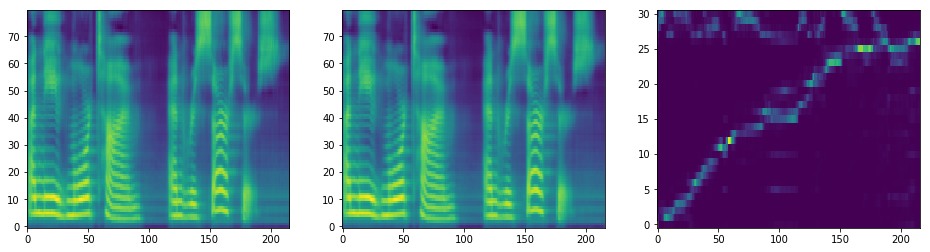

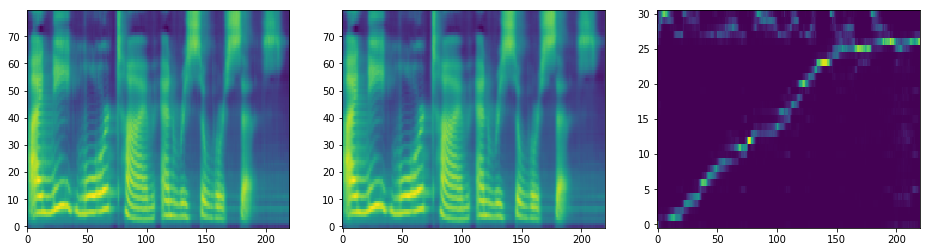

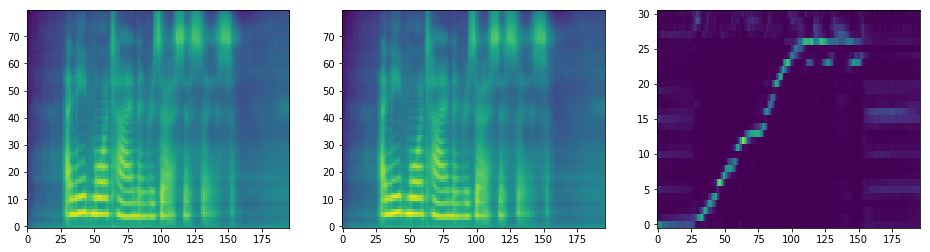

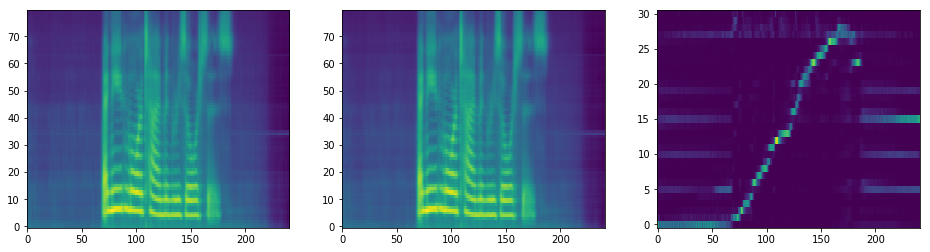

In [26]:
audios = []
for k, v in models.items():
    audios.append(make_inference(v, text, 'speaker_audio/leviOsa.wav'))
for audio in audios:
    ipd.display(ipd.Audio(audio, rate=hparams.sampling_rate))

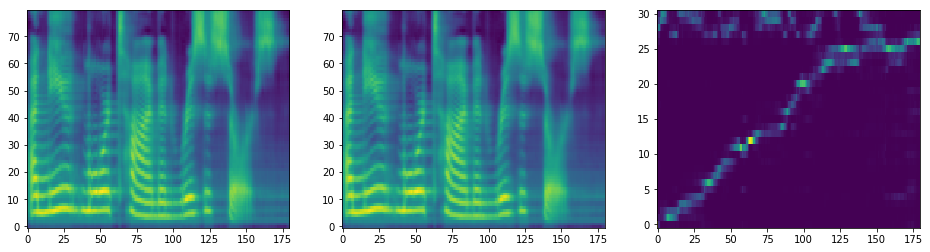

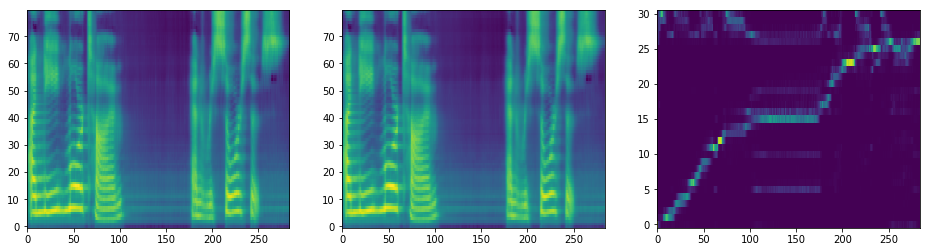

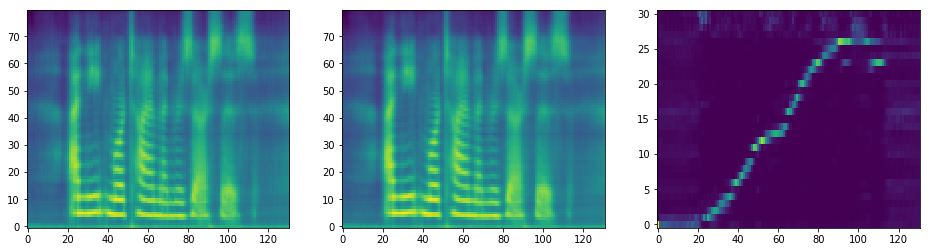

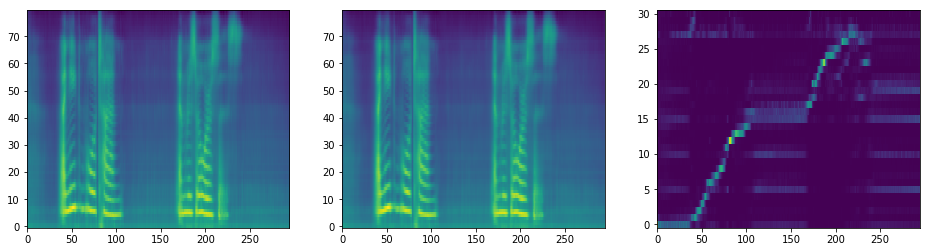

In [22]:
audios = []
for k, v in models.items():
    audios.append(make_inference(v, text, 'speaker_audio/ariana.wav'))
for audio in audios:
    ipd.display(ipd.Audio(audio, rate=hparams.sampling_rate))

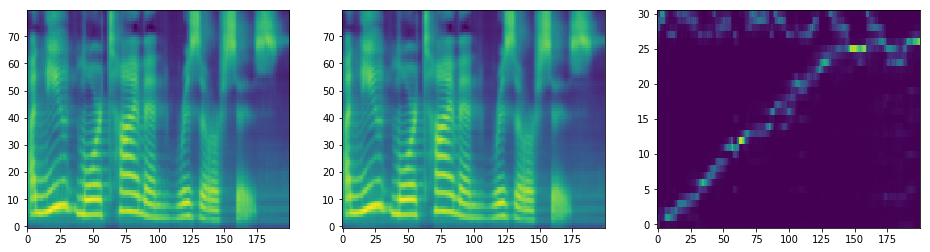

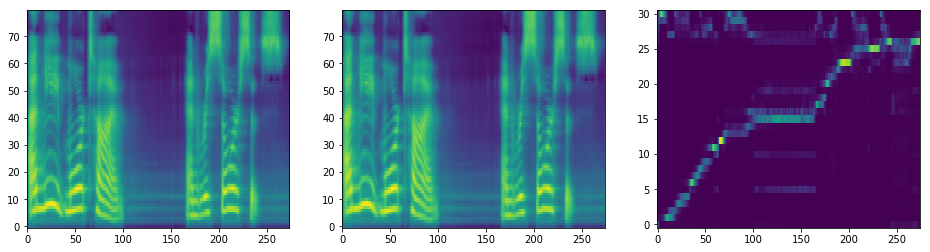

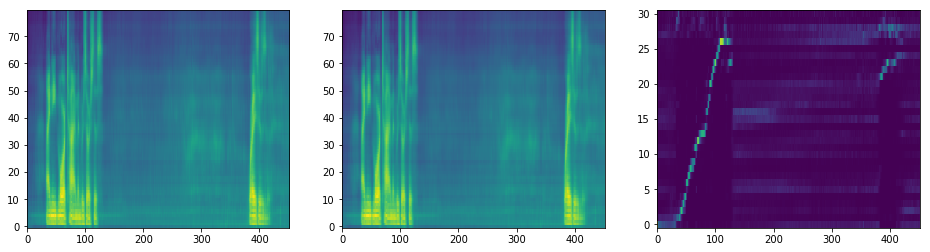

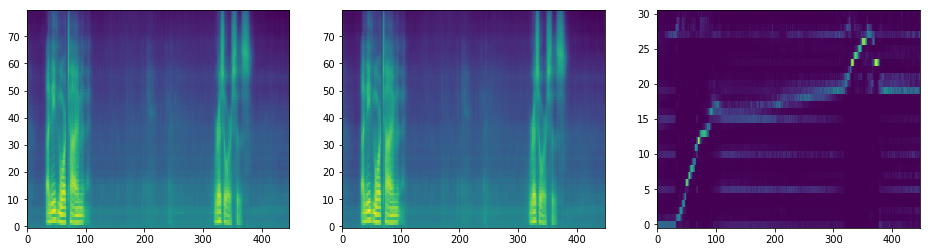

In [39]:
audios = []
for k, v in models.items():
    audios.append(make_inference(v, text, 'speaker_audio/elon_musk.wav'))
for audio in audios:
    ipd.display(ipd.Audio(audio, rate=hparams.sampling_rate))

Warning! Reached max decoder steps


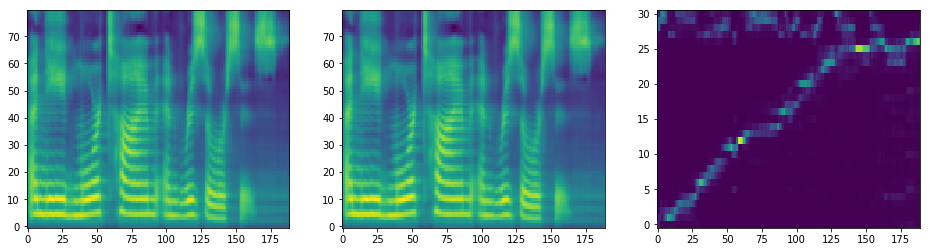

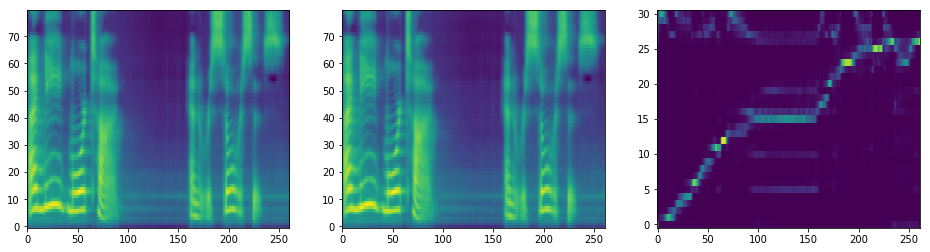

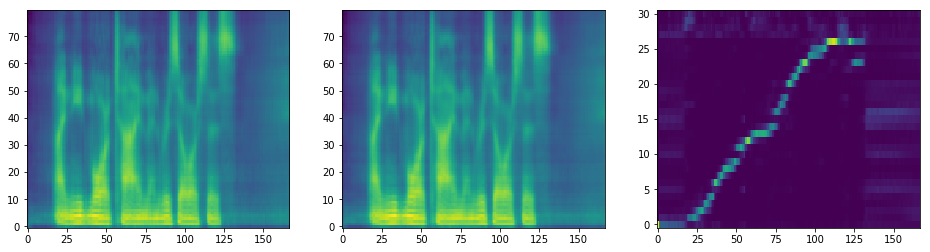

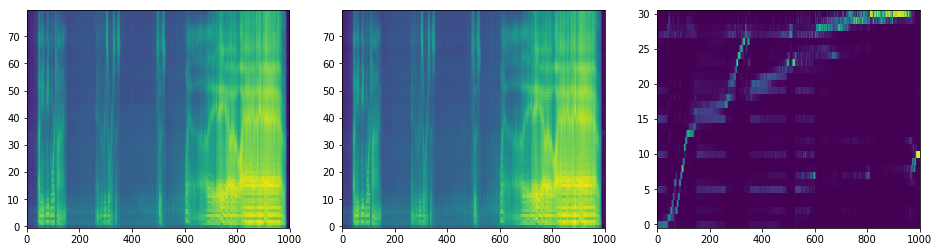

In [41]:
audios = []
for k, v in models.items():
    audios.append(make_inference(v, text, 'speaker_audio/obama.wav'))
for audio in audios:
    ipd.display(ipd.Audio(audio, rate=hparams.sampling_rate))